# Astropy tutorial @ ASTRON
# Using PyVO to explore LOTSS and TGSS data

Author: [Tammo Jan Dijkema](t.j.dijkema@gmail.com)

This tutorial first given at ASTRON on 13 March 2019

In [3]:
import pyvo as vo

In [24]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We will extract some sources from a more or less random cutout of the LoTSS HETDEX field.

In [41]:
lotss_center = SkyCoord(ra=195.89191*u.deg, dec=49.74803*u.deg)

The capabilities of all tables on the ASTRON VO-server are listed on https://vo.astron.nl/ . In particular, for LoTSS, the list of fields is documented [here](https://vo.astron.nl/hetdex/lotss-dr1/cone/info).

In [42]:
lotss_query = vo.dal.scs.SCSQuery('https://vo.astron.nl/hetdex/lotss-dr1/cone/scs.xml')
lotss_query['RA'] = lotss_center.ra.to(u.deg).value
lotss_query['DEC'] = lotss_center.dec.to(u.deg).value
lotss_query.radius = 1.5*u.deg

Unfortunately `pyvo` does not understand astropy units: the ra and dec need to be given in degrees without unit.

In [44]:
lotss_table = lotss_query.execute().to_table()

In [45]:
lotss_table[:5]

Source_Name,RA,E_RA,DEC,E_DEC,Peak_flux,E_Peak_flux,Total_flux,E_Total_flux,Major,E_Maj,Minor,E_Min,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Masked_Fraction,ID_flag,ID_name,ID_ra,ID_dec,ML_LR,LGZ_Size,LGZ_Width,LGZ_PA,LGZ_Assoc,LGZ_Assoc_Qual,LGZ_ID_Qual,Deblended_from,AllWISE,objid,gFApFlux,gFApFluxErr,gFApMag,gFApMagErr,rFApFlux,rFApFluxErr,rFApMag,rFApMagErr,iFApFlux,iFApFluxErr,iFApMag,iFApMagErr,zFApFlux,zFApFluxErr,zFApMag,zFApMagErr,yFApFlux,yFApFluxErr,yFApMag,yFApMagErr,gFKronFlux,gFKronFluxErr,rFKronFlux,rFKronFluxErr,iFKronFlux,iFKronFluxErr,zFKronFlux,zFKronFluxErr,yFKronFlux,yFKronFluxErr,W1Flux,W1FluxErr,W1Mag,W1MagErr,W2Flux,W2FluxErr,W2Mag,W2MagErr,W3Flux,W3FluxErr,W3Mag,W3MagErr,W4Flux,W4FluxErr,W4Mag,W4MagErr,z_best,z_best_source,z_spec,z_spec_source,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,specAGN,mqcAGN,XrayClass,_2RXS_ID,XMMSL2_ID,IRClass,EBV,PanSTARRS_Missing,u_rest,g_rest,r_rest,i_rest,z_rest,U__rest,B_rest,V_rest,I__rest,J_rest,Ks_rest,w1_rest,w2_rest,w3_rest
,deg,arcsec,deg,arcsec,mJy/beam,mJy/beam,mJy,mJy,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,deg,deg,deg,deg,mJy/beam,,,,,,deg,deg,,arcsec,arcsec,deg,,,,,,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,object,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ILTJ131101.27+503649.8,197.755298235285,0.621449001406682,50.6138537119503,0.221122379367781,0.386148307292531,0.0534210305285419,0.425988774462365,0.0932860834840265,--,1.46361481518271,--,0.519493071175322,0.0,1.46361481518271,0.0,0.519493071175322,90.8987522033729,14.7526460822876,0.0,14.7526460822876,0.0550119184481446,S,P34Hetdex06,0.0,1,PSO J131101.362+503649.578,197.75564789,50.61377251,347.133477921727,--,--,--,--,--,--,,J131101.30+503649.7,,1.86666945633135,1.44367241301316,23.222331446692,0.839702712926741,0.997904488443382,0.622793483695054,23.9022775599254,0.677609371604232,6.17290164970658,0.868225358940128,21.9237766060311,0.152709983016695,14.4341241048792,2.57282371989593,21.0015239123745,0.193528047899161,15.6070847846177,7.41744082239141,20.9166955258464,0.516008220539602,2.56776893630048e-06,1.30077265423184e-06,1.23298628546559e-06,8.15227917967764e-07,6.25157608437465e-06,1.25279965900595e-06,1.45255111584377e-05,2.44757075737054e-06,1.52522122684537e-05,1.35679870655598e-05,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.8848,0.0,--,--,0.8848,0.4556,1.3297,0.796,--,--,--,--,,0,0.0,,,0,0.0139,--,-20.5409613508517,-22.0739579470814,-22.8448487510067,-23.1629436412186,-23.5119128804571,--,-21.7863417804376,-22.5345513096806,--,-23.8566087293678,-23.9072091711578,-23.3777655575066,--,--
ILTJ131131.20+503026.2,197.879986488083,0.589555101394212,50.5072940044737,0.702180966758866,0.360952858157179,0.0702258397588345,0.596115043339907,0.104608162967654,--,1.71288457955039,--,1.31429394435552,5.75890900792082,1.71288457955039,3.88858425

In [46]:
len(lotss_table)

7197

**Exercise**: Query the same region in TGSS (TIFR GMRT Sky Survey) alternative data release, available from `https://vo.astron.nl/tgssadr/q/cone/scs.xml`, store the result in `tgss_table`

In [49]:
tgss_table[:5]

ID,RA,e_RA,DEC,e_DEC,Sint,e_Sint,Spk,e_Spk,MAJAX,e_MAJAX,MINAX,e_MINAX,PA,e_PA,Island_RMS,S_Code,Mosaic_Name
,deg,arcsec,deg,arcsec,mJy,mJy,mJy/beam,mJy/beam,arcsec,arcsec,arcsec,arcsec,deg,deg,mJy/beam,,
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
J131128.1+502514,197.86739,2.0,50.42066,2.0,725.3,72.6,635.0,63.5,27.8,0.1,25.7,0.1,-32.3,2.2,2.3,S,R40D64
J131216.0+500605,198.06668,2.0,50.10156,2.0,2131.7,213.3,1034.3,103.5,43.5,0.1,25.9,0.1,9.4,0.3,2.3,M,R40D64
J131212.0+500651,198.05014,2.1,50.11438,2.1,36.9,5.5,38.9,4.5,24.4,1.4,24.3,1.4,14.9,0.4,2.3,C,R40D64
J131052.8+500412,197.7202,2.6,50.07018,2.4,50.7,6.2,26.6,3.6,43.2,4.6,27.5,2.1,-57.6,10.8,2.3,S,R40D64
J130945.9+500724,197.44145,2.1,50.1236,2.1,67.1,7.7,54.3,5.9,29.5,1.3,26.1,1.1,-6.8,15.3,2.2,S,R40D64


In [50]:
len(tgss_table)

151

To perform a cross match, we only look at brighter sources in LoTSS:

In [51]:
lotss_selection = lotss_table[lotss_table['Total_flux']>20]

Cross matching is done on SkyCoord objects. We make one SkyCoord object for a lot of coordinates:

In [52]:
lotss_sources = SkyCoord(ra=lotss_selection['RA'], dec=lotss_selection['DEC'])

In [53]:
tgss_sources = SkyCoord(ra=tgss_table['RA'], dec=tgss_table['DEC'])

Matching is done with `match_to_catalog_sky`. This gives for every TGSS source the closest LoTSS source, and the distance to this. (A more thorough crossmatch would use either ADQL queries or `search_around_sky`, which gives a many-to-many relationship.

In [54]:
lotss_idx, dist_2d, _ = tgss_sources.match_to_catalog_sky(lotss_sources)

In [55]:
lotss_idx

array([  1,   2,   3,   6,   7,   8,   9,  10,  18,  22,  23,  24,  25,
        26,  27,  29,  37,  33,  35,  37,  39,  40,  41,  42,  43,  44,
        45,  48,  50,  51,  52,  53,  54,  54,  57,  58,  58,  59,  60,
        61,  63,  65,  67,  67,  68,  69,  71,  72,  73,  76,  77,  78,
        80,  80,  82,  83,  84,  85,  86,  88,  89,  92,  93,  94,  95,
        95,  96,  98,  99, 100, 101, 102, 102, 104, 106, 107, 108, 112,
       114, 116, 117, 118, 119, 123, 125, 127, 128, 129, 130, 132, 133,
       135, 136, 136, 136, 137, 140, 141, 142, 144, 144, 145, 146, 147,
       148, 151, 152, 154, 155, 156, 157, 158, 159, 160, 163, 161, 162,
       163, 166, 168, 169, 171, 172, 173, 174, 176, 177, 182, 183, 184,
       185, 186, 189, 190, 192, 193, 193, 195, 197, 199, 200, 201, 203,
       204, 205, 205, 208, 209, 210, 211, 212])

**Exercise**: Are all these matches good? Have a look at `dist_2d`.

**Exercise**: plot `lotss_selection[lotss_idx]["Total flux"]` against `tgss_table["Sint"]`. Filter the results to use only the points where `dist2d<10*u.arcsec`.

## Image access

In [27]:
tgss_service = vo.dal.sia.SIAService('https://vo.astron.nl/tgssadr/q_fits/imgs/siap.xml')

In [28]:
lotss_service = vo.dal.sia.SIAService('https://vo.astron.nl/hetdex/lotss-dr1-img/imgs/siap.xml')

In [29]:
res = lotss_service.search(pos=lotss_center, size=0.01)

In [30]:
res['imageTitle']

masked_array(data=[b'P34Hetdex06-low-residual-mosaic',
                   b'P34Hetdex06-residual-mosaic',
                   b'P34Hetdex06-low-mosaic', b'P34Hetdex06-mosaic',
                   b'P34Hetdex06-mosaic-rms'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object)

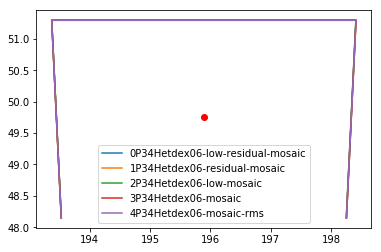

In [31]:
fig, ax = plt.subplots()
for num, cov in enumerate(res['coverage']):
    ax.plot(cov[::2], cov[1::2], label=str(num)+res['imageTitle'][num].decode('utf-8'));
ax.plot([lotss_center.ra.to(u.deg).value], [lotss_center.dec.to(u.deg).value], 'ro');
ax.legend();

In [32]:
import astropy.io.fits as fits

In [33]:
res['accref'][2].decode('utf-8')

'https://vo.astron.nl/getproduct/hetdex/data/low-mosaics/P34Hetdex06-low-mosaic.fits'

In [34]:
f = fits.open(res['accref'][2].decode('utf-8'))

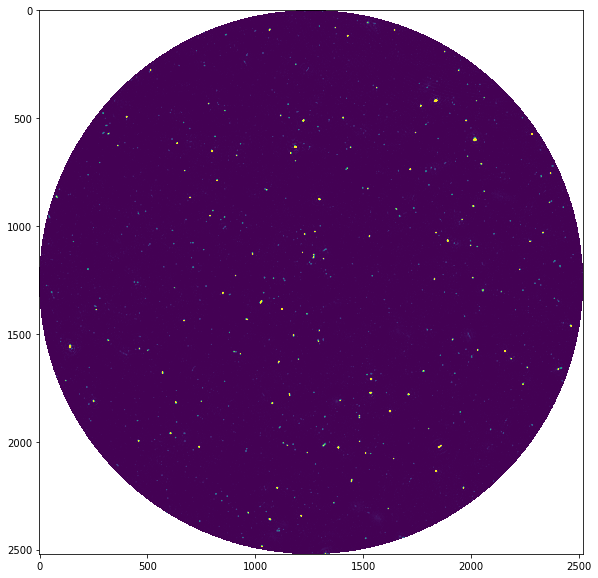

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(f[0].data.squeeze(),
          vmin=0,
          vmax=np.percentile(f[0].data[np.logical_not(np.isnan(f[0].data))], 99.9)
         );

It would of course be better to add proper axes.

In [36]:
from astropy.wcs import WCS

In [37]:
wcs = WCS(f[0])

In [38]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 195.89191  49.74803  
CRPIX : 1260.0  1260.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00125  0.00125  
NAXIS : 2520  2520

In [58]:
def plot_lotss(tgss_dots=False, lotss_dots=False, lotss_flux_min=100):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    ax.imshow(f[0].data.squeeze(),
              vmin=0,
              vmax=np.percentile(f[0].data[np.logical_not(np.isnan(f[0].data))], 99.9)
             );
    if lotss_dots:
        lotss_subset = lotss_table[lotss_table["Total_flux"]>lotss_flux_min]
        ax.plot(lotss_subset["RA"], lotss_subset["DEC"], 'ro', transform=ax.get_transform('world'),
               label="LoTSS catalog > {}mJy".format(lotss_flux_min));            
    if tgss_dots:
        ax.plot(tgss_table["RA"], tgss_table["DEC"], 'y.', transform=ax.get_transform('world'),
               label="TGSS catalog");
    ax.legend()
    return ax

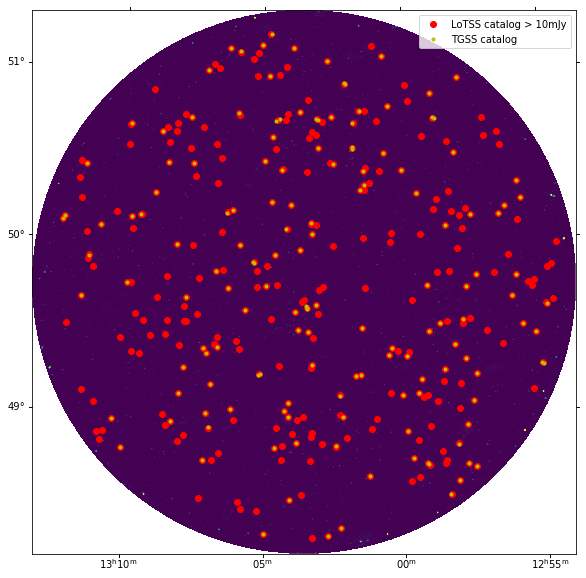

In [59]:
plot_lotss(tgss_dots=True, lotss_dots=True, lotss_flux_min=10);

In [102]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider

In [103]:
interact(plot_lotss, lotss_flux_min=FloatSlider(min=0, max=150, step=5, continuous_update=False));

interactive(children=(Checkbox(value=False, description='tgss_dots'), Checkbox(value=False, description='lotss…